In [1]:
!pip install yfinance --upgrade --no-cache-dir
!pip install pandas-datareader --upgrade --no-cache-dir


In [1]:
#import
import tensorflow as tf

#univariate one step problem with lstm
from numpy import array
from tensorflow.keras.models import Sequential # Import from tensorflow.keras
from tensorflow.keras.layers import Dense,  LSTM # Import from tensorflow.keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # Import from tensorflow.keras

#Estas son paqueterías complementarias para la descarga de datos financieros
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf

#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

#Plots
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Obtain data

In [2]:
#Establecemos las fechas de consulta:
start = '2015-01-01'
end = '2024-12-31'

#Variables
variables = ['AMZN','AAPL','IBM', 'GOOGL']

#Obtain data
# Instead of using pdr.get_data_yahoo directly, use yf.download
amzn = yf.download("AMZN", start=start, end=end)['Close']
data_variables = yf.download(variables, start=start, end=end)['Close']

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  4 of 4 completed


In [3]:
dt = pd.DataFrame(amzn)
dt.head()

Ticker,AMZN
Date,
2015-01-02,15.4260
2015-01-05,15.1095
2015-01-06,14.7645
2015-01-07,14.9210
2015-01-08,15.0230


In [4]:
dt.tail()

Ticker,AMZN
Date,
2024-12-23,225.059998
2024-12-24,229.050003
2024-12-26,227.050003
2024-12-27,223.750000
2024-12-30,221.300003


In [5]:
data_variables.head()

Ticker,AAPL,AMZN,GOOGL,IBM
Date,,,,
2015-01-02,24.320438,15.4260,26.351517,99.992134
2015-01-05,23.635281,15.1095,25.849415,98.418793
2015-01-06,23.637516,14.7645,25.211468,96.296272
2015-01-07,23.968962,14.9210,25.137320,95.666962
2015-01-08,24.889904,15.0230,25.224903,97.746216


In [7]:
data_variables.tail()  #los regresores exógenos

Ticker,AAPL,AMZN,GOOGL,IBM
Date,,,,
2024-12-23,254.989655,225.059998,194.406113,220.461243
2024-12-24,257.916443,229.050003,195.884399,222.924835
2024-12-26,258.735504,227.050003,195.375000,223.401657
2024-12-27,255.309296,223.750000,192.538254,221.305618
2024-12-30,251.923019,221.300003,191.020004,218.792374


# Plot the series

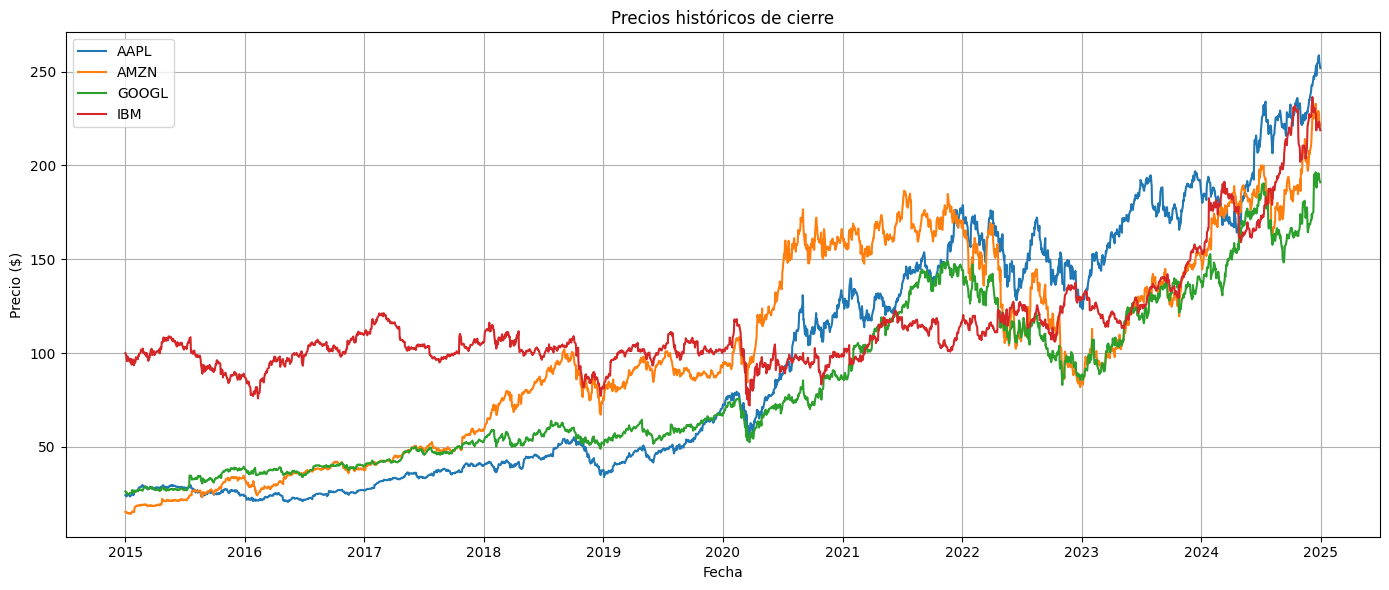

In [6]:
plt.figure(figsize=(14, 6))

for col in data_variables.columns:
    plt.plot(data_variables.index, data_variables[col], label=col)

plt.title("Precios históricos de cierre")
plt.xlabel("Fecha")
plt.ylabel("Precio ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Preprocess the data Enfoque 1

In [7]:
dataindex = pd.to_datetime(dt.index)  # Convertimos el índice del dataFrame (que contiene fechas) al tipo datetime64 de pandas, por si aún no lo estaba.
dataindex

DatetimeIndex(['2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07',
               '2015-01-08', '2015-01-09', '2015-01-12', '2015-01-13',
               '2015-01-14', '2015-01-15',
               ...
               '2024-12-16', '2024-12-17', '2024-12-18', '2024-12-19',
               '2024-12-20', '2024-12-23', '2024-12-24', '2024-12-26',
               '2024-12-27', '2024-12-30'],
              dtype='datetime64[ns]', name='Date', length=2515, freq=None)

### Outcome variable

In [8]:
output_data = amzn.to_numpy().reshape((-1,1)) #a una columna y tantas filas como datos haya en shape =(N,1), una columna (1)
output_data

array([[ 15.42599964],
       [ 15.10949993],
       [ 14.76449966],
       ...,
       [227.05000305],
       [223.75      ],
       [221.30000305]])

### Predict variables

In [12]:
input_data = data_variables.to_numpy().reshape((len(data_variables),len(data_variables.columns)))
input_data

array([[ 24.32043266,  15.42599964,  26.35151482,  99.99214172],
       [ 23.6352787 ,  15.10949993,  25.84941483,  98.41876221],
       [ 23.63751221,  14.76449966,  25.21146774,  96.29627228],
       ...,
       [258.73550415, 227.05000305, 195.375     , 223.4016571 ],
       [255.30929565, 223.75      , 192.53825378, 221.30561829],
       [251.92301941, 221.30000305, 191.02000427, 218.79237366]])

# Train and test data; data definition

In [15]:
split_percent = 0.90
split = int(split_percent*len(output_data))
n_back = 10

date_train = dataindex[:split]
date_test = dataindex[split:]

train_generator = TimeseriesGenerator(input_data[:split], output_data[:split], length=n_back, batch_size=25)  #se generan las secuencias donde se entrenan 10  (n_back) y aprende de y (t=11). Cada lote de 25, son 4 features (AMZN, AAPL, IBM, GOOGL),
test_generator = TimeseriesGenerator(input_data[split:], output_data[split:], length=n_back, batch_size=1)   # con batch de 1, se predice punto a punto.

In [16]:
print(len(input_data[:split]))
print(len(input_data[split:]))
print(len(input_data))

2263
252
2515


In [17]:
print('Samples: %d' % len(train_generator))   #Numero de lotes o samples son 91 (2263-n_back/25) para entrenamiento. Número de secuencias: 2263-n_back o 2253
print('Samples: %d' % len(test_generator))    # numero de lotes en test: 252-n_back o 242.

# Con batch size de 25, quedaría la dinámica de entranamiento asi:
# Batch 1 : secuencias 0 - 24 y se actualizan pesos
# Bathc 2 : secuencias 25 - 49 y se actualizan pesos
#...
# Batch 90 : secuencias 2225 - 2249 y se actualizan pesos
#Batch 91 : secuencias 2250 - 2253 y actualiza pesos

Samples: 91
Samples: 242


# Train the model

In [18]:
#Configuramos la de red.
model = Sequential()   #Modelo de capas apiladas, linealmente
#Capa LSTM ppal:
model.add(
    LSTM(100, activation='relu', input_shape=(n_back, len(data_variables.columns)))  #acá generamos pronostico para todos (n_features)
)
#Capa salida:
model.add(Dense(len(data_variables.columns)))  #definimos que prediciremos todas las variables, sale un vestor de 4 elementos.
model.compile(optimizer='adam', loss='mse') ##algoritmo de optimización y función de pérdida.

#Entrenamiento;
num_epochs = 50
# Use model.fit instead of model.fit_generator
model.fit(train_generator, epochs=num_epochs, verbose=0)   #Se entrena con el modelo de secuencias ya listas de train_generator, 50 vueltas completas sbre datos de entrenamiento. No impirmimos nada de barra de progreso.

In [23]:
!pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.7 MB/s eta 0:00:00


##Mejoremos el modelo: 2 capas LSTM, Dropout (evita overfitting), Earlystopping, validación.


Trial 10 Complete [00h 01m 07s]
val_loss: 375.7509765625

Best val_loss So Far: 25.079601287841797
Total elapsed time: 00h 27m 45s
✅ Mejores hiperparámetros encontrados:
  units: 64
  dropout: 0.1
  optimizer: rmsprop
Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 2544027.5000 - val_loss: 5264.0562
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 536.8800 - val_loss: 428.3405
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 356.0713 - val_loss: 527.4705
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 310.2947 - val_loss: 377.5018
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 275.4038 - val_loss: 255.6883
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 239.9037 - val_loss: 405.6511
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 227.5163 - val_loss: 101.3864
Epoch 8/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 187.5687 - val_loss: 103.6488
Epoch 9/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 187.73

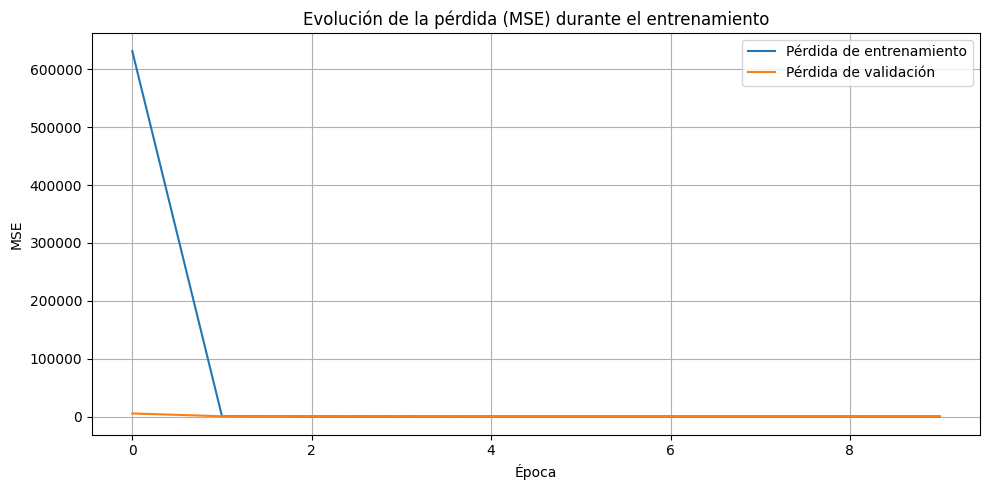

In [32]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # Import TimeseriesGenerator

import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
#from keras.preprocessing.sequence import TimeseriesGenerator #depreciated
import matplotlib.pyplot as plt

def optimize_lstm_multivariate(input_data, output_data, dataindex,
                               n_back=10, split_percent=0.9,
                               batch_size=32, max_trials=10, epochs=50,
                               fast_mode=False):

    # Ajuste rápido
    if fast_mode:
        max_trials = 2
        epochs = 10
        print("MODO RÁPIDO ACTIVADO: max_trials=2, epochs=10")

    split = int(split_percent * len(output_data))

    train_generator = TimeseriesGenerator(input_data[:split], output_data[:split],
                                          length=n_back, batch_size=batch_size)
    test_generator = TimeseriesGenerator(input_data[split:], output_data[split:],
                                         length=n_back, batch_size=1)

    def build_model(hp):
        model = Sequential()
        units = hp.Int('units', min_value=32, max_value=128 if fast_mode else 256, step=32)
        dropout_rate = hp.Float('dropout', min_value=0.1, max_value=0.3 if fast_mode else 0.5, step=0.1)
        model.add(LSTM(units, activation='relu', return_sequences=True, input_shape=(n_back, input_data.shape[1])))
        model.add(Dropout(dropout_rate))
        model.add(LSTM(units // 2, activation='relu'))
        model.add(Dropout(dropout_rate))
        model.add(Dense(input_data.shape[1]))
        optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
        optimizer = Adam() if optimizer_choice == 'adam' else RMSprop()
        model.compile(optimizer=optimizer, loss='mse')
        return model

    tuner = kt.RandomSearch(
        build_model,
        objective='val_loss',
        max_trials=max_trials,
        executions_per_trial=1,
        directory='lstm_tuning',
        project_name='amzn_multivariate'
    )

    tuner.search(train_generator, validation_data=test_generator, epochs=epochs, verbose=1)

    best_model = tuner.get_best_models(num_models=1)[0]
    best_hp = tuner.get_best_hyperparameters(1)[0]

    print("✅ Mejores hiperparámetros encontrados:")
    for k, v in best_hp.values.items():
        print(f"  {k}: {v}")

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = best_model.fit(
        train_generator,
        validation_data=test_generator,
        epochs=50 if not fast_mode else 10,
        callbacks=[early_stop],
        verbose=1
    )

    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida de validación')
    plt.title('Evolución de la pérdida (MSE) durante el entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return best_model, best_hp

best_model, best_hp = optimize_lstm_multivariate(
    input_data=input_data,
    output_data=output_data,
    dataindex=dataindex,
    n_back=10,
    batch_size=25,
    max_trials=10,
    epochs=50,
    fast_mode=True  # 👈 activa modo rápido
)


In [49]:
from sklearn.metrics import mean_squared_error
import numpy as np

# 7) Evaluación automática sobre el test set
print("\n Evaluación del modelo en el set de prueba...")

# Predicciones
y_pred = best_model.predict(test_generator)

# Valores reales (alineados por n_back)
split = int(split_percent * len(output_data))
y_true = output_data[split + n_back:]

# Ensure both y_true and y_pred have the same number of output columns
# Assuming you want to evaluate for the first column (AMZN):
#y_true = y_true[:, 0]  # Select the first column of y_true # Fixed: Remove this line as y_true is already 1D
y_pred = y_pred[:, 0]  # Select the first column of y_pred


# MSE y RMSE totales
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
print(f" * MSE total en test: {mse:.4f}")
print(f" * RMSE total en test: {rmse:.4f}")

# RMSE para AMZN (columna 0)
rmse_amzn = np.sqrt(mean_squared_error(y_true, y_pred))  # Now y_true and y_pred are 1D
print(f" * RMSE en test para AMZN: {rmse_amzn:.4f}")


 Evaluación del modelo en el set de prueba...
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
 * MSE total en test: 109.1114
 * RMSE total en test: 10.4456
 * RMSE en test para AMZN: 10.4456


# Forecast in the test data

In [37]:
# Predicción en el set de prueba usando el mejor modelo
prediction = best_model.predict(test_generator)

# Alineamos las etiquetas reales (AMZN) del set de test
split = int(0.9 * len(output_data))  # Usa el mismo split que en la función
n_back = 10
y_true = output_data[split + n_back:]

# Extraer solo la columna de AMZN (suponiendo que está en la primera columna)
prediction_amzn = prediction[:, 0]


242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [39]:
#Podemos primeramente graficar las secciones: la serie de entrenamiento, la predicción en la sección de prueba y la sección de prueba.
trace1 = go.Scatter(
    x = date_train, y = output_data[:split],
    mode = 'lines', name = 'Data'
)
trace2 = go.Scatter(
    x = date_test[n_back:], y = prediction_amzn,
    mode = 'lines', name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test, y = output_data[split:],
    mode='lines', name = 'Ground Truth'
)
layout = go.Layout(
    title = "AMZN Stock",
    xaxis = {'title':"Date"},
    yaxis = {'title':"Close"}
)

fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

# Forecast the future data

In [41]:
# -------------------------
# Parámetros
steps = 20                # Pasos hacia el futuro
n_back = 10               # Ventana temporal (igual que en entrenamiento)
n_features = input_data.shape[1]  # Número de variables

# -------------------------
# Última secuencia observada real
forecast_input = input_data[-n_back:].copy().reshape((1, n_back, n_features))

# Lista para almacenar predicciones futuras
forecast = []

for _ in range(steps):
    # Predecir siguiente paso
    pred = best_model.predict(forecast_input, verbose=0)[0]  # (n_features,)
    forecast.append(pred)

    # Actualizar la ventana: quitar el paso más viejo y agregar la nueva predicción
    forecast_input = np.roll(forecast_input, -1, axis=1)  # mueve todo 1 paso atrás
    forecast_input[0, -1, :] = pred  # insertamos nueva predicción al final

# Convertir forecast a DataFrame
forecast_df = pd.DataFrame(forecast, columns=data_variables.columns)

# Fechas futuras
forecast_dates = pd.date_range(start=dataindex[-1], periods=steps + 1, freq='D')[1:]
forecast_df['Date'] = forecast_dates
forecast_df.set_index('Date', inplace=True)

# Mostrar los primeros pasos del forecast
forecast_df.head()


Ticker,AAPL,AMZN,GOOGL,IBM
Date,,,,
2024-12-31,233.620316,229.570786,231.837463,229.642075
2025-01-01,230.741119,226.265869,228.778000,226.875916
2025-01-02,234.016205,229.317764,233.238190,234.231079
2025-01-03,239.975067,236.863571,239.574539,241.235626
2025-01-04,241.950806,239.830872,242.076843,243.934708


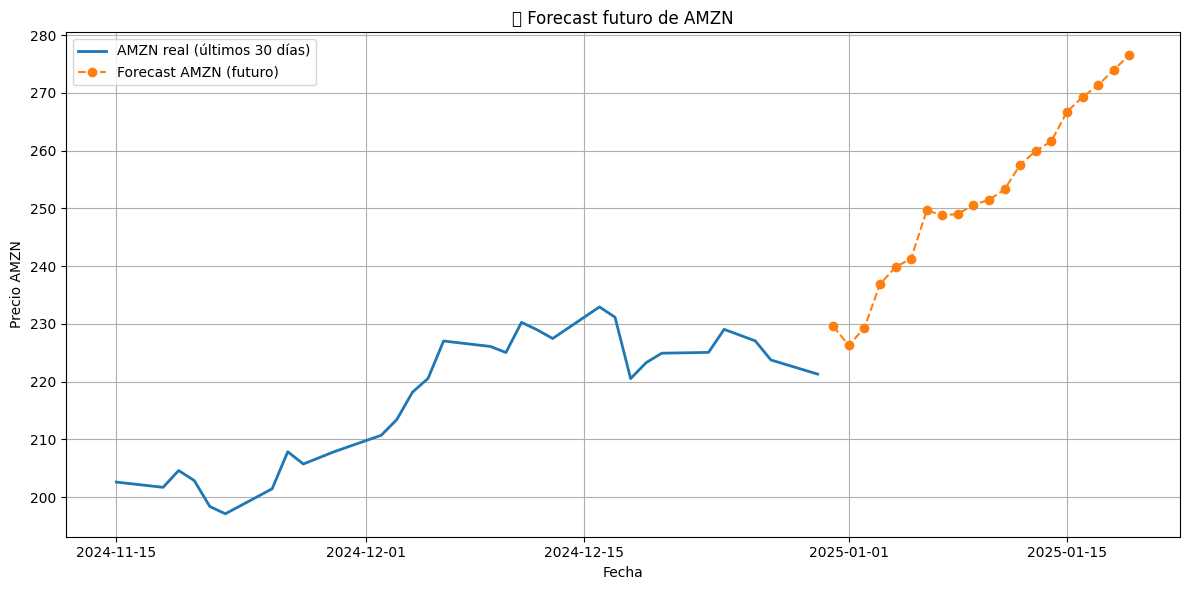

In [43]:
import matplotlib.pyplot as plt

# Cuántos datos reales recientes mostrar
n_recent = 30

# Extraer la serie real final (por ejemplo, últimos 30 días)
#real_amzn = output_data[-n_recent:, 0]  # solo AMZN
real_amzn = output_data[-n_recent:] # Fijo: Accessamos al 1D array with single index, AMZN
real_dates = dataindex[-n_recent:]

# Predicción futura
forecast_amzn = forecast_df['AMZN']
forecast_dates = forecast_df.index

# -----------------------------
# Gráfico
plt.figure(figsize=(12, 6))
plt.plot(real_dates, real_amzn, label='AMZN real (últimos 30 días)', linewidth=2)
plt.plot(forecast_dates, forecast_amzn, label='Forecast AMZN (futuro)', linestyle='--', marker='o')

plt.title('📈 Forecast futuro de AMZN')
plt.xlabel('Fecha')
plt.ylabel('Precio AMZN')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [47]:
import plotly.graph_objects as go

# Cuántos días recientes mostrar (puedes ajustar)
n_recent = 30

# Serie real (últimos días)
real_amzn = output_data[-n_recent:]  # Access the 1D array with a single index
real_dates = dataindex[-n_recent:]

# Serie predicha hacia el futuro
forecast_amzn = forecast_df['AMZN']
forecast_dates = forecast_df.index

# Crear trazos
trace_real = go.Scatter(
    x=real_dates,
    y=real_amzn,
    mode='lines+markers',
    name='AMZN real (últimos días)'
)

trace_forecast = go.Scatter(
    x=forecast_dates,
    y=forecast_amzn,
    mode='lines+markers',
    name='Forecast AMZN (futuro)',
    line=dict(dash='dash')
)

# Layout
layout = go.Layout(
    title='📈 Predicción futura de AMZN',
    xaxis=dict(title='Fecha'),
    yaxis=dict(title='Precio AMZN'),
    template='plotly_white'
)

# Figura
fig = go.Figure(data=[trace_real, trace_forecast], layout=layout)
fig.show()